# Импорты, функции

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
# from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [2]:
import regr_metrics_func

In [2]:
def rmse(y_true, y_pred):
    mean_squared_error = np.mean((y_true - y_pred) ** 2)  # Среднее значение квадратов ошибок
    return np.sqrt(mean_squared_error)


def check_MO_regression(model_obj, model_name=""):
    MO_regr = {'Indep': MultiOutputRegressor, 'Chain': RegressorChain}
    for name, model in MO_regr.items():
        y_pred = model(model_obj).fit(X_train, y_train).predict(X_test)
        print(f"{model_name} {name}. RMSE: {round(rmse(y_test, y_pred), 3)}")
    return(None)


def plot_nn_losses(hist):
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return(None)

# Подготовка данных

In [3]:
data = pd.read_feather("../0. Data/wide_data.feather")

X = data.loc[:, ~data.columns.isin(["HL_1", "HL_2", "HL_3", "HL_4", "HL_5", "HL_6", "id"])]
y = data.loc[:, "HL_1":"HL_6"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=242)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
y_bool = pd.read_feather("../0. Data/Y_bool.feather")

y_b_train, y_b_test = train_test_split(y_bool, test_size=0.2, random_state=42)

# Классификация

In [6]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_b_train)

# 5. Предсказание и оценка
y_pred = model.predict(X_test)


# Проверка, что ровно 3 шкалы выбраны (важно для задачи)
print("Пример предсказания:", y_pred[0])  # Например, [1, 0, 1, 1, 0, 0]

# Метрики
print("Accuracy:", accuracy_score(y_b_test, y_pred))
print(classification_report(y_b_test, y_pred, target_names=y_b_test.columns))

Пример предсказания: [ True  True  True False False False]
Accuracy: 0.014705882352941176
              precision    recall  f1-score   support

        HL_1       0.53      0.61      0.56        33
        HL_2       0.57      0.68      0.62        40
        HL_3       0.42      0.53      0.47        32
        HL_4       0.43      0.28      0.34        36
        HL_5       0.38      0.31      0.34        29
        HL_6       0.50      0.53      0.51        34

   micro avg       0.49      0.50      0.49       204
   macro avg       0.47      0.49      0.47       204
weighted avg       0.48      0.50      0.48       204
 samples avg       0.49      0.50      0.48       204



In [6]:
probs = model.predict_proba(X_test)
probs[2]

NameError: name 'model' is not defined

# Регрессионные модели

## Обычные регрессоры, поддерживающие MultiOutput по умолчанию

In [6]:
linear = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=500).fit(X_train, y_train)
etr = ExtraTreesRegressor().fit(X_train, y_train)
knn = KNeighborsRegressor().fit(X_train, y_train)

print(f"Linear. RMSE: {rmse(y_test, linear.predict(X_test))}")
print(f"ExtraTree. RMSE: {rmse(y_test, etr.predict(X_test))}")
print(f"Random Forest. RMSE: {rmse(y_test, rf.predict(X_test))}")
print(f"kNN. RMSE: {rmse(y_test, knn.predict(X_test))}")

Linear. RMSE: 2.2039390281741458
ExtraTree. RMSE: 1.9975936504096279
Random Forest. RMSE: 2.0098420189598163
kNN. RMSE: 2.2846890207572295


In [12]:
regr_metrics_func.calc_C_index(y_test, linear.predict(X_test))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Бустинги

In [5]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

lgb_params = {
    'metric': 'rmse',
    'learning_rate': 0.05,
    'seed': 42,
    'verbose': -1
}

lgb_model = MultiOutputRegressor(lgb.LGBMRegressor(**lgb_params)).fit(X_train, y_train)
xgbst = xgb.train(xgb_params, xgb.DMatrix(X_train, label=y_train), 15)
ctb = CatBoostRegressor(iterations=100, random_seed=42, loss_function='MultiRMSE', verbose=0).fit(X_train, y_train)

print(f"LightGBM. RMSE: {rmse(y_test, lgb_model.predict(X_test))}")
print(f"XGBoost. RMSE: {rmse(y_test, xgbst.predict(xgb.DMatrix(X_test, label=y_test)))}")
print(f"XGB. RMSE: {rmse(y_test, ctb.predict(X_test))}")

ModuleNotFoundError: No module named 'xgboost'

## MultiOutputRegressor и RegressorChain

In [7]:
check_MO_regression(RandomForestRegressor(n_estimators=500, random_state=42), "Random Forest")

Random Forest Indep. RMSE: 2.019
Random Forest Chain. RMSE: 2.047


RMSE: 2.1939639438160112 для n_est=1000  
RMSE: 2.2284464935263317 для n_est=100  
RMSE: 2.1941610460671366 для n_est=500

In [12]:
check_MO_regression(LinearRegression(), "Linear")

Linear Indep. RMSE: 2.204
Linear Chain. RMSE: 2.204


In [13]:
check_MO_regression(SVR(kernel='linear'), "SVR linear")
check_MO_regression(SVR(kernel='poly'), "SVR poly")
check_MO_regression(SVR(kernel='rbf'), "SVR rbf")

SVR linear Indep. RMSE: 2.341
SVR linear Chain. RMSE: 2.296
SVR poly Indep. RMSE: 2.174
SVR poly Chain. RMSE: 2.124
SVR rbf Indep. RMSE: 2.067
SVR rbf Chain. RMSE: 2.059


In [19]:
check_MO_regression(KNeighborsRegressor(n_neighbors=15), "kNN")

kNN Indep. RMSE: 2.116
kNN Chain. RMSE: 2.138


## Нейронные сети

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [9]:
tf_model = Sequential([
    Dense(128, input_dim=55, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6)
])

tf_model.compile(optimizer='adam', loss='mse')
    
history = tf_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

y_pred = tf_model.predict(X_test)
print(f"RMSE: {rmse(y_test, y_pred)}")

RMSE: 2.405842291033797


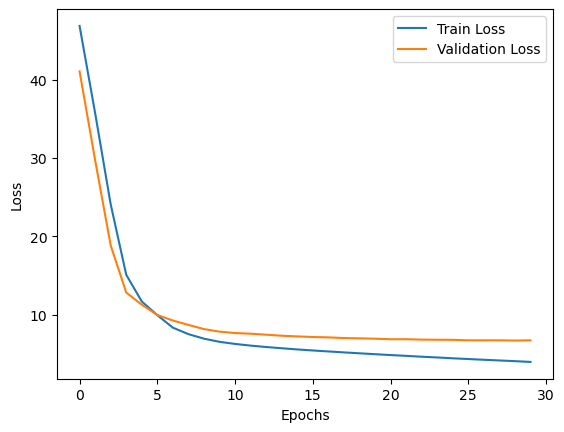

In [10]:
plot_nn_losses(history)

Более сложная модель с промежуточными слоями

In [11]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(55,)),  # Входной слой для 55 признаков
        
        # Нормализация входных данных
        layers.experimental.preprocessing.Normalization(axis=-1),
        
        # Скрытые слои с регуляризацией
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Выходной слой с 6 нейронами (для 6 целевых признаков)
        layers.Dense(6)
    ])
    
    return model

In [12]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Используем MSE как функцию потерь
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Оценка модели
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MSE: {test_results[0]:.2f}, Test RMSE: {test_results[1]:.2f}")



Test MSE: 5.52, Test RMSE: 2.09


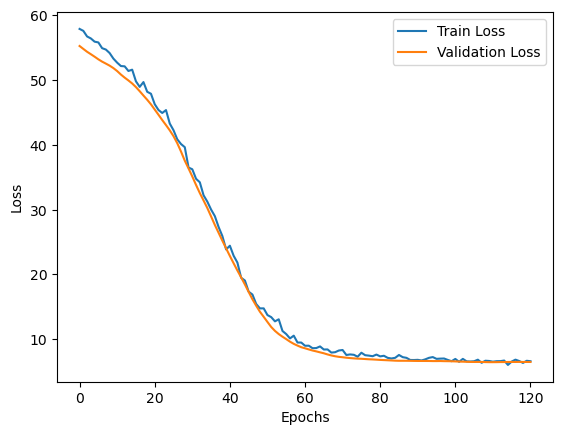

In [13]:
plot_nn_losses(history)

Прежде всё работало на env 3.8, tabpfn на base 3.12

In [38]:
from tabpfn import TabPFNRegressor

# tab_model = RegressorChain(TabPFNRegressor()).fit(X_train, y_train)

# y_tabpfn_pred = tab_model.predict(X_test)
# print(f"RMSE: {rmse(y_test, y_tabpfn_pred)}")

ImportError: cannot import name 'TabPFNRegressor' from 'tabpfn' (d:\Programs\anaconda3\envs\env\lib\site-packages\tabpfn\__init__.py)

tabpfn (обучался почти 9 минут) - rmse 2.217

In [ ]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

OSError: [WinError 127] Не найдена указанная процедура. Error loading "d:\Programs\anaconda3\Lib\site-packages\torch\lib\c10_cuda.dll" or one of its dependencies.